In [1]:
# Import statements
#import statements
import numpy as np
import copy
import math
import pandas as pd
from scipy.optimize import curve_fit
import os
import warnings
from astropy.stats import sigma_clip
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='serif')
rc('mathtext', fontset='cm')

%matplotlib notebook

full_file_list = os.listdir('full') # creates a Python list containing the file paths for every object's time series

len(full_file_list)

28108

In [2]:
# Create functions to extract data

def load_one_timeseries(file_name):
    """
    Function to access light curve data for one object.
    
    Parameters
    ---
    file_name : str
        File path to CFHTLS time series data file (eg. 'CFHTLS-VAR-J022359.77-041810.1.mjdmag')
        
    Returns
    ---
    field : str
        CFHTLS field (D1, D2, D3, or D4) object is found in
    timestamps : ndarray
        Array of recorded times for each measurement
    mags : ndarray
        Array of measured magnitude for each measurement
    magerrs : ndarray
        Array of measurement error in magnitude for each measurement
    expnums : ndarray
        Array of the MegaCam exposure number in which each measurement can be found
    int_filters : ndarray
        Array of integers representing each CFHTLS filter indicating what filter each magnitude was measured in
        (u = 0, g = 1, r = 2, i1 = 3, i2 = 4, z = 5 - there were two different I-band filters)
    num_entries : int
        Total number of measurements
     with open('full/'+file_name) as data_file:
    """
    timestamps = []
    mags = []
    magerrs = []
    expnums = []
    filters = []

    with open('full/'+file_name) as data_file:
        first_line = data_file.readline()
        field = (first_line.split())[2]
        for line in data_file:
            if not line.startswith('#'):
                data = line.split()
                timestamps.append(data[0])
                mags.append(data[1])
                magerrs.append(data[2])
                expnums.append(data[3])
                filters.append(data[8])

    timestamps = np.asarray(timestamps, dtype=float)
    mags = np.asarray(mags, dtype=float)
    magerrs = np.asarray(magerrs, dtype=float)
    expnums = np.asarray(expnums, dtype=int)

    int_filters = np.empty(len(filters), dtype=int)
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        int_filters[np.where(np.asarray(filters)=='U')[0]] = 0
        int_filters[np.where(np.asarray(filters)=='G')[0]] = 1
        int_filters[np.where(np.asarray(filters)=='R')[0]] = 2
        int_filters[np.where(np.asarray(filters)=='I')[0]] = 3
        int_filters[np.where(np.asarray(filters)=='I2')[0]] = 4
        int_filters[np.where(np.asarray(filters)=='Z')[0]] = 5
        
    num_entries = len(timestamps)
    
    return field, timestamps, mags, magerrs, expnums, int_filters, num_entries


def get_num_measurements(file_list, by_filter=False):
    """
    Function to obtain the number of measurements in each time series file.
    
    Parameters
    ---
    file_list : list of str
        List of file paths (eg. one created by os.listdir(folder_path))
    by_filter : bool
        Defaults to False. Set to true to return an array containing number of measurements per filter
        
    Returns
    ---
    num_measurements : ndarray
        Array containing number of time series measurements per object
        If by_filter=False, Nx1 array, where N = number of objects
        If by_filter=True, NxM array, where N = number of objects and M = number of filters
    
    """
    if by_filter==False:
        num_measurements = np.empty(len(file_list))
        for i, fname in enumerate(file_list):
            _, _, _, _, _, _, num = load_one_timeseries(fname)
            num_measurements[i] = num
    elif by_filter==True:
        num_measurements = np.empty((len(file_list), 6))
        for i, fname in enumerate(file_list):
            _, _, _, _, _, filters, _ = load_one_timeseries(fname)
            for j in range(6):
                num_measurements[i,j] = np.sum(filters==j)
    return num_measurements



In [3]:
num_measurements = get_num_measurements(full_file_list)
file_list = (np.asarray(full_file_list))[num_measurements>15]
num_measurements_by_filter = get_num_measurements(file_list, by_filter=True)
#there must be at least 15 measurements per band for an object for us to use it
file_list = file_list[np.all(num_measurements_by_filter>=15, axis=1)]

In [4]:
def get_rms_by_median(magnitudes, bool_array):
    true_mags =  [mag_val for (mag_val,bool_val) in zip(magnitdues,bool_array) if bool_val == True]
    median = np.median(true_magnitudes)
    return math.sqrt(np.mean([((i - median) * (i-median) for i in true_mags)]))
    
    
def convert_i1_to_i2(i1_magnitudes): #converts i1 magnitudes to i2
                     
    i2_magnitudes = []
    x = range(len(i1_magnitudes))
    for i in x:
        conversion = 0.04 * (medians[i, 1] - medians[i, 3]) + i1_magnitudes[i] - 0.076
        i2_magnitudes.append(conversion)
    return i2_magnitudes  
    
  
def get_medians(file_list):
    medians = np.empty((len(file_list), 6))
    for i, fname in enumerate(file_list):
        _, _, mags, _, _, filters, _ = load_one_timeseries(fname)
        for j in range(6):
            medians[i,j] = np.median(mags[filters==j])
    return medians

def get_boolean_array_5 (boolean_array, magnitudes,sigma_val):
    """
    Function that returns boolean values indicating whether measurement was sigma clipped (true = not sigma clipped; false = sigma clipped)
    Parameters
    ---
    boolean_array: array of true false values (i.e.: u_boolean, r_boolean)
    magnitudes: array of magnitudes (i.e.: u_mags, r_mags)
    Returns
    ---
    new_boolean_array: array of true false values
    """
    true_mags = []
    true_mags = [boolean_array[i] for i in range(len(magnitudes)) if boolean_array[i] == True]
    rms = get_rms_by_median(magnitudes, boolean_array)
    for i in range (len(magnitudes)):
        if boolean_array[i] == True:
            if abs((magnitudes[i] - np.median(true_mags))/rms) > sigma_val:
                boolean_array[i] = False
    return boolean_array

                     
medians = get_medians(file_list)

    
#downloading data
magnitudes_raw_data = []
magnitudes_raw_errors = []
filters_raw_data = []
fnames = []
fields = []
for fname in file_list:
    field, _, magnitudes, magnitudes_errors, _, filters, _ = load_one_timeseries(fname)
    magnitudes_raw_data.append(magnitudes)
    magnitudes_raw_errors.append(magnitudes_errors)
    filters_raw_data.append(filters)
    fnames.append(fname)
    fields.append(field)
    
    
#creating 6 empty lists for each object, each object is an element in the overall 3d list
all_mags = []
for i in range(len(magnitudes_raw_data)):
    all_mags.append([[],[],[],[],[],[]])
    
#creating 6 empty lists for each object, each object is an element in the overall 3d list
all_mags_errs = []
for i in range(len(magnitudes_raw_errors)):
    all_mags_errs.append([[],[],[],[],[],[]])

In [5]:
print("magnitudes length:" + str(len(magnitudes)))
print("magnitudes_errors length:" + str(len(all_mags_errs)))
'''
print("magnitudes" + str(magnitudes))
print("magnitudes_errors" + str(all_mags_errs))
'''

magnitudes length:2973
magnitudes_errors length:26820


'\nprint("magnitudes" + str(magnitudes))\nprint("magnitudes_errors" + str(all_mags_errs))\n'

In [6]:
#deleting '.mjdmag' from file name of each object
for fname in fnames:
    for i in range(len(fnames)):
        fnames[i] = fname.replace(".mjdmag", "")
        
                
#sort measurements by filter
for i in range(len(magnitudes_raw_data)):
    all_mags[i][0] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 0] #u
    all_mags[i][1] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 1] #g
    all_mags[i][2] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 2] #r
    all_mags[i][3] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 3] #i1
    all_mags[i][4] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 4] #i2
    all_mags[i][5] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 5] #z

#sort measurements by filter
for i in range(len(magnitudes_raw_data)):
    all_mags_errs[i][0] = [magnitudes_raw_errors[i][j] for j in range(len(magnitudes_raw_errors[i])) if filters_raw_data[i][j] == 0] #u
    all_mags_errs[i][1] = [magnitudes_raw_errors[i][j] for j in range(len(magnitudes_raw_errors[i])) if filters_raw_data[i][j] == 1] #g
    all_mags_errs[i][2] = [magnitudes_raw_errors[i][j] for j in range(len(magnitudes_raw_errors[i])) if filters_raw_data[i][j] == 2] #r
    all_mags_errs[i][3] = [magnitudes_raw_errors[i][j] for j in range(len(magnitudes_raw_errors[i])) if filters_raw_data[i][j] == 3] #i1
    all_mags_errs[i][4] = [magnitudes_raw_errors[i][j] for j in range(len(magnitudes_raw_errors[i])) if filters_raw_data[i][j] == 4] #i2
    all_mags_errs[i][5] = [magnitudes_raw_errors[i][j] for j in range(len(magnitudes_raw_errors[i])) if filters_raw_data[i][j] == 5] #z

#i_one_converted = convert_i1_to_i2(i_one_mags)
#i_two_mags.extend(i_one_converted)

#convert i1 to i2 through predefined function 'convert_i1_to_i2'
for i in range(len(all_mags)):
    i_one_converted = convert_i1_to_i2(all_mags[i][3])
    all_mags[i][4].extend(i_one_converted)
    
    i_one_converted = convert_i1_to_i2(all_mags_errs[i][3])
    all_mags_errs[i][4].extend(i_one_converted)

    
#remove original i1 measurements from 3d list
for i in range(len(all_mags)):
    all_mags[i].remove(all_mags[i][3])
    all_mags_errs[i].remove(all_mags_errs[i][3])

#create a copy of all_mags
all_mags_2 = []
for i in range(len(all_mags)):
    all_mags_2.append([[],[],[],[],[]])


for i in range(len(all_mags)):
    for j in range(len(all_mags[i])):
            all_mags_2[i][j] = copy.deepcopy(all_mags[i][j])

all_mags_copy = copy.deepcopy(all_mags)


#5 sigma clip all_mags 
for i in range(len(all_mags)):
    all_mags[i][0] = sigma_clip(all_mags[i][0],sigma=5,maxiters=3,masked=False,copy=False)
    all_mags[i][1] = sigma_clip(all_mags[i][1],sigma=5,maxiters=3,masked=False,copy=False)
    all_mags[i][2] = sigma_clip(all_mags[i][2],sigma=5,maxiters=3,masked=False,copy=False)
    all_mags[i][3] = sigma_clip(all_mags[i][3],sigma=5,maxiters=3,masked=False,copy=False)
    all_mags[i][4] = sigma_clip(all_mags[i][4],sigma=5,maxiters=3,masked=False,copy=False)
    

#5 sigma clip all_mags_copy and RETURN MASKED
for i in range(len(all_mags_copy)):
    all_mags_copy[i][0] = sigma_clip(all_mags_copy[i][0],sigma=5,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][1] = sigma_clip(all_mags_copy[i][1],sigma=5,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][2] = sigma_clip(all_mags_copy[i][2],sigma=5,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][3] = sigma_clip(all_mags_copy[i][3],sigma=5,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][4] = sigma_clip(all_mags_copy[i][4],sigma=5,maxiters=3,masked=True,copy=False)
    


In [7]:
print(len(all_mags))
print(len(all_mags_errs))

26820
26820


In [13]:
#GET MJD VALS

#downloading mjd data
mjd_raw = []
for fname in file_list:
    _, mjd,_, _, _, filters, _ = load_one_timeseries(fname)
    mjd_raw.append(mjd)

#creating 3d list
all_mjd = []
for i in range(len(mjd_raw)):
    all_mjd.append([[],[],[],[],[]])
    
#sorting mjd by band
for i in range(len(mjd_raw)):
    all_mjd[i][0] = [mjd_raw[i][j] for j in range(len(mjd_raw[i])) if filters_raw_data[i][j] == 0] #u
    all_mjd[i][1] = [mjd_raw[i][j] for j in range(len(mjd_raw[i])) if filters_raw_data[i][j] == 1] #g
    all_mjd[i][2] = [mjd_raw[i][j] for j in range(len(mjd_raw[i])) if filters_raw_data[i][j] == 2] #r
    all_mjd[i][3] = [mjd_raw[i][j] for j in range(len(mjd_raw[i])) if filters_raw_data[i][j] == 3 or filters_raw_data[i][j] == 4] #i
    all_mjd[i][4] = [mjd_raw[i][j] for j in range(len(mjd_raw[i])) if filters_raw_data[i][j] == 5] #z

#delete mjd of sigma clipped data
for i in range(len(all_mags_copy)):
    for j in range(len(all_mags_copy[i])):
        temp_mask = np.ma.getmaskarray(all_mags_copy[i][j])
        all_mjd[i][j] = np.delete(all_mjd[i][j], temp_mask)
        all_mags_errs[i][j] = np.delete(all_mags_errs[i][j], temp_mask)

In [14]:
#Code to generate random object (Unnecessary for us)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


from gatspy import datasets, periodic
'''
# Choose a Sesar 2010 object to base our fits on
lcid = 1019544
rrlyrae = datasets.RRLyraeGenerated(lcid, random_state=0)

# Generate data in a 6-month observing season
Nobs = 60
rng = np.random.RandomState(0)

nights = np.arange(180)
rng.shuffle(nights)
nights = nights[:Nobs]

t = 57000 + nights + 0.05 * rng.randn(Nobs)
dy = 0.06 + 0.01 * rng.randn(Nobs)
mags = np.array([rrlyrae.generated(band, t, err=dy, corrected=False)
                 for band in 'ugriz'])
"""
All the above are not necessary for the NGVS_legacy work, becuase you do have realistic data.
I generate mock datesets just to test to code and show an example result.
"""

"""
Here start the fitting process. 
t, mags, dy, filts are all N-d arraies of your observation data. They mean observation time in MJD, apperent magnitudes, errors, and filter list, respectively
If you do not have error list, set dy to be all ones.
filts could be anything in the format of np.array(['u','u','g', ..., 'z']), as long as its elements are filter names and its length equal to the mags array
"""

filts = np.take(list('ugriz'), np.arange(Nobs), mode='wrap') 
# 
mags = mags[np.arange(Nobs) % 5, np.arange(Nobs)]
masks = [(filts == band) for band in 'ugriz']
'''



'\n# Choose a Sesar 2010 object to base our fits on\nlcid = 1019544\nrrlyrae = datasets.RRLyraeGenerated(lcid, random_state=0)\n\n# Generate data in a 6-month observing season\nNobs = 60\nrng = np.random.RandomState(0)\n\nnights = np.arange(180)\nrng.shuffle(nights)\nnights = nights[:Nobs]\n\nt = 57000 + nights + 0.05 * rng.randn(Nobs)\ndy = 0.06 + 0.01 * rng.randn(Nobs)\nmags = np.array([rrlyrae.generated(band, t, err=dy, corrected=False)\n                 for band in \'ugriz\'])\n"""\nAll the above are not necessary for the NGVS_legacy work, becuase you do have realistic data.\nI generate mock datesets just to test to code and show an example result.\n"""\n\n"""\nHere start the fitting process. \nt, mags, dy, filts are all N-d arraies of your observation data. They mean observation time in MJD, apperent magnitudes, errors, and filter list, respectively\nIf you do not have error list, set dy to be all ones.\nfilts could be anything in the format of np.array([\'u\',\'u\',\'g\', ..., \'

In [144]:
star_index = 48
mags = []
t = []
dy = []
filts =[]
#for i in all_mags_errs:   
    #print(type(i))
for band in range(5):
    mags.extend(all_mags[star_index][band])
    dy.extend(abs(all_mags_errs[star_index][band]))
    t.extend(all_mjd[star_index][band])
#dy = [1 for i in range(len(t))]
'''
for i in range(int(len(mags)/5)):
    filts.extend(['u','g','r','i','z'])
filts.extend('u')
#filts.append('g')
#filts.append('r')
'''
filts = np.take(list('ugriz'), np.arange(len(mags)), mode='wrap') 
masks = [(filts == band) for band in 'ugriz']

#print(len(mags))
#print(mags)
#print(len(filts))
#print(len(dy))
#print(dy)
#print(filts)
for i in range(len(dy)):
    if dy[i] < 0.001:
        dy[i] = 0.001
      
print(dy)

[0.06, 0.072, 0.064, 0.076, 0.172, 0.106, 0.079, 0.079, 0.084, 0.096, 0.083, 0.079, 0.062, 0.057, 0.056, 0.079, 0.092, 0.077, 0.046, 0.06, 0.074, 0.053, 0.072, 0.089, 0.132, 0.058, 0.164, 0.071, 0.101, 0.059, 0.287, 0.049, 0.059, 0.039, 0.061, 0.05, 0.078, 0.077, 0.079, 0.221, 0.119, 0.319, 0.048, 0.033, 0.056, 0.076, 0.035, 0.049, 0.027, 0.027, 0.048, 0.032, 0.024, 0.024, 0.04, 0.033, 0.027, 0.045, 0.045, 0.035, 0.032, 0.055, 0.044, 0.036, 0.037, 0.036, 0.033, 0.025, 0.028, 0.028, 0.024, 0.04, 0.037, 0.029, 0.031, 0.035, 0.028, 0.023, 0.045, 0.03, 0.033, 0.035, 0.032, 0.032, 0.03, 0.048, 0.044, 0.025, 0.031, 0.028, 0.021, 0.022, 0.02, 0.032, 0.035, 0.037, 0.024, 0.047, 0.04, 0.046, 0.028, 0.026, 0.067, 0.03, 0.031, 0.031, 0.037, 0.033, 0.031, 0.038, 0.032, 0.078, 0.028, 0.032, 0.026, 0.03, 0.035, 0.031, 0.051, 0.033, 0.033, 0.049, 0.031, 0.032, 0.049, 0.044, 0.057, 0.034, 0.04, 0.033, 0.032, 0.034, 0.035, 0.032, 0.02, 0.021, 0.028, 0.04, 0.034, 0.026, 0.031, 0.026, 0.031, 0.028, 0.029

In [155]:
periods = np.linspace(0.1, 1, 50000) # This defines the search range of your period, you can specify it at your will

model = periodic.NaiveMultiband(BaseModel=periodic.LombScargleFast) 

# specify the method to be the naive multiband LS, which means you fit data in each band separately, and get a score list for each band.
# serves as a good first try on your NGVS_legacy data
model.fit(t, mags, dy, filts) 
P = model.scores(periods) 

# This is the fitting score list you want. 
# It is a 5xN array, P[0] is the fit socres of periods with your u band data. And so on for P[1] for g, P[2] for i, ...
# Each element in P[i] correspond to a period in the array periods you input. The closer to 1, the better.


LS_multi = periodic.LombScargleMultiband(Nterms_base=1, Nterms_band=0)

LS_multi.fit(t, mags, dy, filts)
P_multi = LS_multi.periodogram(periods)
# A non-naive way of multiband fitting. This time all data from all bands are fitted simultaneously, means you do not get scores for each band separately.
# P_multi will be a 1-d array, has equal length to your input periods. The maximum value in P_multi will be the best fit, and its corresponding period will be the best period.


C:\Users\spenc\anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


<IPython.core.display.Javascript object>


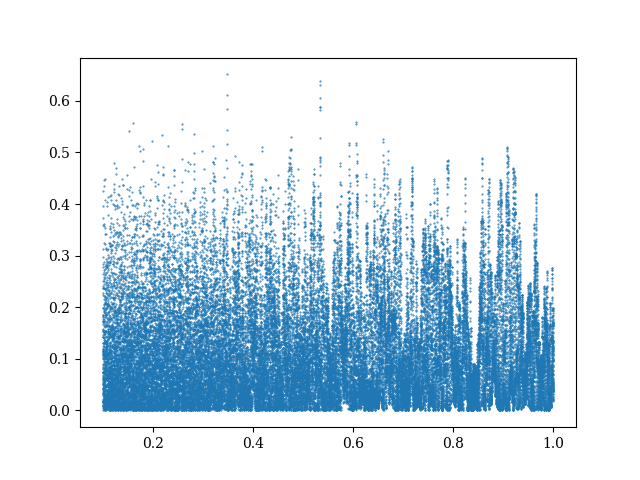

In [156]:
plt.figure()
plt.scatter(periods,P_multi,s=0.2)
plt.show()

In [149]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import sklearn.metrics

In [150]:
'''
from scipy.optimize import curve_fit
#model function
def f(x, a, b,c):
    return a * np.sin(b*x + c)
    #return a*(x) + b 


#raw data plotted with curve fit
plt.plot(periods, P_multi, 'o', label='data', markersize=1)

popt, pcov = curve_fit(f, periods, P_multi)




#r = np.sort(np.append(periods,P_multi))
'''
'''best fit curve. change the decimal after 5. for a and b to change how many
#places past the decimal are visible '''
'''
plt.plot(periods, f(periods, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.legend()
plt.show()
'''

"\nplt.plot(periods, f(periods, *popt), 'r-',\n         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))\n\nplt.legend()\nplt.show()\n"

In [151]:
#Magnitudes on y-axis, MJD % period for axis

In [152]:
def plot_unfolded_light_curve(star_object):
    """
    Function to create unfolded light curve plots for the object of interest
    
    Parameters
    ---
    objects: index for the object of interest in file_list
    
    Returns
    ---
    plots of magnitude vs MJD for the object
    """

    plt.figure(figsize = (9, 12))
    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.scatter(all_mjd[star_object][0], all_mags[star_object][0], s = 5, c = 'blue', label = 'u')
    plt.scatter(all_mjd[star_object][1], all_mags[star_object][1], s = 5, c = 'green', label = 'g')
    plt.scatter(all_mjd[star_object][2], all_mags[star_object][2], s = 5, c = 'purple', label = 'r')
    plt.scatter(all_mjd[star_object][3], all_mags[star_object][3], s = 5, c = 'gold', label = 'i')
    plt.scatter(all_mjd[star_object][4], all_mags[star_object][4], s = 5, c = 'tab:red', label = 'z')
    plt.legend()
    plt.title(fnames[star_object] + " (" + str(star_object) + ")")
    plt.show()
'''
def plot_unfolded_light_curve(objects):
    """
    Function to create unfolded light curve plots for all objects of interest
    
    Parameters
    ---
    objects: array of indicies of objects of interest in file_list
    
    Returns
    ---
    plots of magnitude vs MJD for all objects
    """

    for star_object in objects:
        plt.figure(figsize = (9, 12))
        plt.xlabel('MJD')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.scatter(all_mjd[star_object][0], all_mags[star_object][0], s = 5, c = 'blue', label = 'u')
        plt.scatter(all_mjd[star_object][1], all_mags[star_object][1], s = 5, c = 'green', label = 'g')
        plt.scatter(all_mjd[star_object][2], all_mags[star_object][2], s = 5, c = 'purple', label = 'r')
        plt.scatter(all_mjd[star_object][3], all_mags[star_object][3], s = 5, c = 'gold', label = 'i')
        plt.scatter(all_mjd[star_object][4], all_mags[star_object][4], s = 5, c = 'tab:red', label = 'z')
        plt.legend()
        plt.title(fnames[star_object] + " (" + str(star_object) + ")")
        plt.show()
'''

'\ndef plot_unfolded_light_curve(objects):\n    """\n    Function to create unfolded light curve plots for all objects of interest\n    \n    Parameters\n    ---\n    objects: array of indicies of objects of interest in file_list\n    \n    Returns\n    ---\n    plots of magnitude vs MJD for all objects\n    """\n\n    for star_object in objects:\n        plt.figure(figsize = (9, 12))\n        plt.xlabel(\'MJD\')\n        plt.ylabel(\'Magnitude\')\n        plt.gca().invert_yaxis()\n        plt.scatter(all_mjd[star_object][0], all_mags[star_object][0], s = 5, c = \'blue\', label = \'u\')\n        plt.scatter(all_mjd[star_object][1], all_mags[star_object][1], s = 5, c = \'green\', label = \'g\')\n        plt.scatter(all_mjd[star_object][2], all_mags[star_object][2], s = 5, c = \'purple\', label = \'r\')\n        plt.scatter(all_mjd[star_object][3], all_mags[star_object][3], s = 5, c = \'gold\', label = \'i\')\n        plt.scatter(all_mjd[star_object][4], all_mags[star_object][4], s = 5, 

In [153]:
def fold_light_curve(star_object,per_max_val):
    plt.figure(figsize = (9, 12))
    plt.xlabel('MJD % Period')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.scatter([i % per_max_val for i in all_mjd[star_object][0]], all_mags[star_object][0], s = 5, c = 'blue', label = 'u')
    plt.scatter([i % per_max_val for i in all_mjd[star_object][1]], all_mags[star_object][1], s = 5, c = 'green', label = 'g')
    plt.scatter([i % per_max_val for i in all_mjd[star_object][2]], all_mags[star_object][2], s = 5, c = 'purple', label = 'r')
    plt.scatter([i % per_max_val for i in all_mjd[star_object][3]], all_mags[star_object][3], s = 5, c = 'gold', label = 'i')
    plt.scatter([i % per_max_val for i in all_mjd[star_object][4]], all_mags[star_object][4], s = 5, c = 'tab:red', label = 'z')
    plt.legend()
    plt.title(fnames[star_object] + " (" + str(star_object) + ")")
    plt.show()
'''
def fold_light_curve(objects,per_max_val):
     for star_object in objects:
        plt.figure(figsize = (9, 12))
        plt.xlabel('MJD % Period')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.scatter([i % per_max_val for i in all_mjd[star_object][0]], all_mags[star_object][0], s = 5, c = 'blue', label = 'u')
        plt.scatter([i % per_max_val for i in all_mjd[star_object][1]], all_mags[star_object][1], s = 5, c = 'green', label = 'g')
        plt.scatter([i % per_max_val for i in all_mjd[star_object][2]], all_mags[star_object][2], s = 5, c = 'purple', label = 'r')
        plt.scatter([i % per_max_val for i in all_mjd[star_object][3]], all_mags[star_object][3], s = 5, c = 'gold', label = 'i')
        plt.scatter([i % per_max_val for i in all_mjd[star_object][4]], all_mags[star_object][4], s = 5, c = 'tab:red', label = 'z')
        plt.legend()
        plt.title(fnames[star_object] + " (" + str(star_object) + ")")
        plt.show()
 '''  
    

'\ndef fold_light_curve(objects,per_max_val):\n     for star_object in objects:\n        plt.figure(figsize = (9, 12))\n        plt.xlabel(\'MJD % Period\')\n        plt.ylabel(\'Magnitude\')\n        plt.gca().invert_yaxis()\n        plt.scatter([i % per_max_val for i in all_mjd[star_object][0]], all_mags[star_object][0], s = 5, c = \'blue\', label = \'u\')\n        plt.scatter([i % per_max_val for i in all_mjd[star_object][1]], all_mags[star_object][1], s = 5, c = \'green\', label = \'g\')\n        plt.scatter([i % per_max_val for i in all_mjd[star_object][2]], all_mags[star_object][2], s = 5, c = \'purple\', label = \'r\')\n        plt.scatter([i % per_max_val for i in all_mjd[star_object][3]], all_mags[star_object][3], s = 5, c = \'gold\', label = \'i\')\n        plt.scatter([i % per_max_val for i in all_mjd[star_object][4]], all_mags[star_object][4], s = 5, c = \'tab:red\', label = \'z\')\n        plt.legend()\n        plt.title(fnames[star_object] + " (" + str(star_object) + ")")

<IPython.core.display.Javascript object>


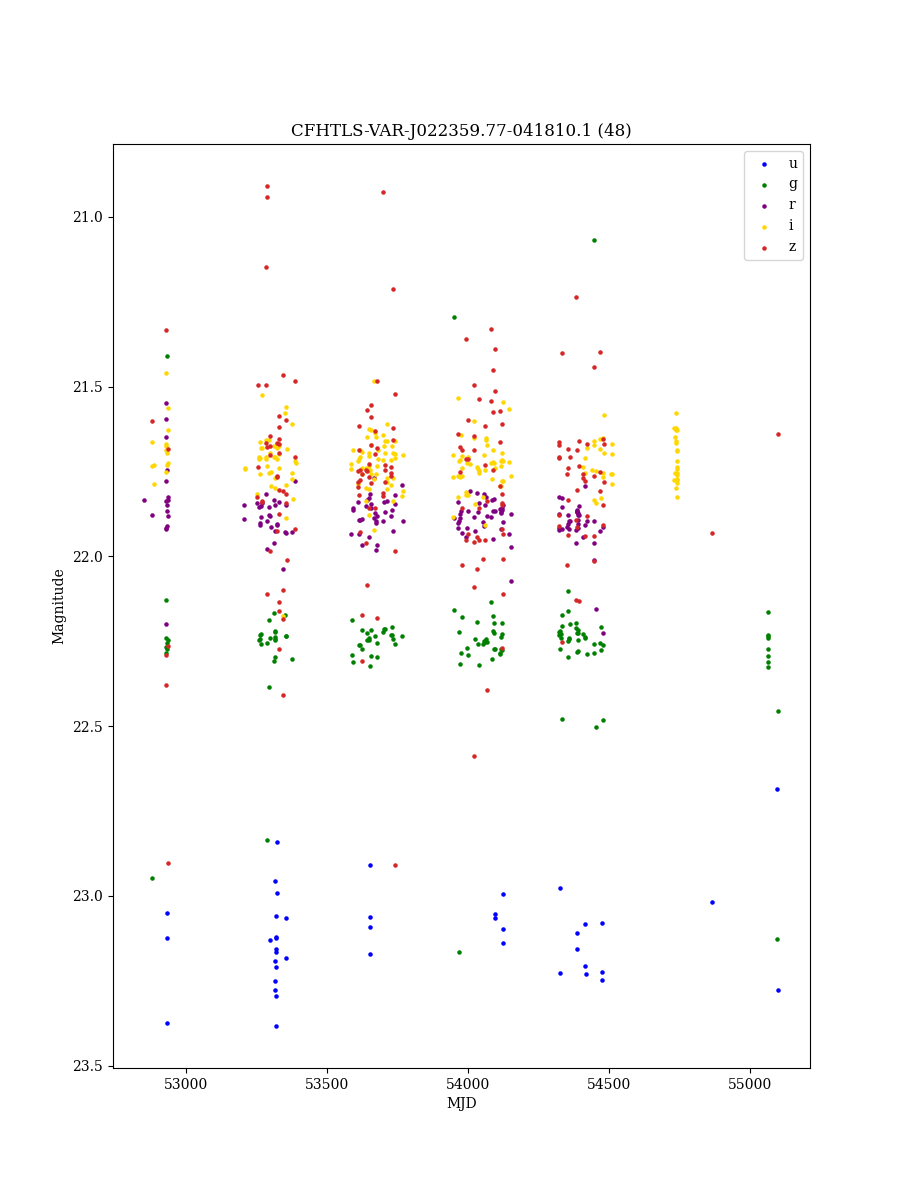

[0.34809896]


<IPython.core.display.Javascript object>


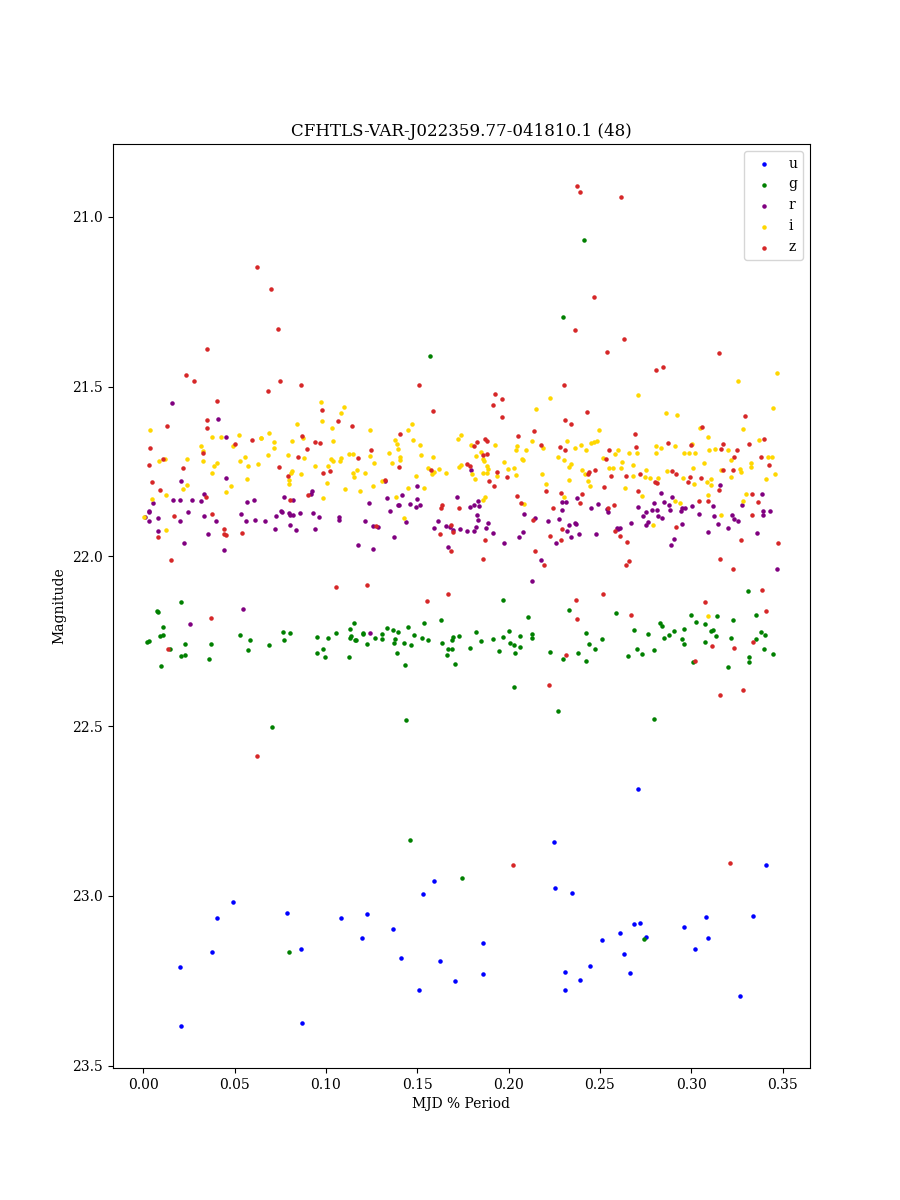

In [157]:
plot_unfolded_light_curve(48)

P_max_index = np.where(P_multi == max(P_multi))
print(periods[P_max_index])
fold_light_curve(48, periods[P_max_index]) 